# Mapillary Vistas Dataset: YOLO Training

-> [V2 downloaded](https://datasetninja.com/mapillary-vistas-dataset)
-> Annotations are in json format -> we have to bring them into yolo format.

In [2]:
from pathlib import Path
from tqdm import tqdm
import json
import random
import logging
from PIL import Image
from shapely.geometry import Polygon, box
from concurrent.futures import ThreadPoolExecutor
import importlib
import config
from config import (
    TEST_LIMIT,
    ROOT_PATH,
    IMAGE_DIR,
    DATA_PATH,
)
from ultralytics import YOLO
import time
import os
import gc


# === Setup ===
logging.basicConfig(level=logging.INFO, format="%(message)s")

# Korrigierter Pfad - die Mapillary Daten haben eine doppelte Verschachtelung
SOURCE_DIR = DATA_PATH / "Mapillary_Vistas"
OUTPUT_DIR = DATA_PATH / "Mapillary_Vistas_Yolo_staged_small"
class_id_map = {}

In [ ]:
def create_dirs():
    for split in ['train', 'val']:
        (OUTPUT_DIR / "images" / split).mkdir(parents=True, exist_ok=True)
        (OUTPUT_DIR / "labels" / split).mkdir(parents=True, exist_ok=True)

def get_split_paths(split_name):
    return {
        "images": SOURCE_DIR / split_name / "images",
        "annotations": SOURCE_DIR / split_name / "v2.0" / "polygons"
    }


def scan_all_classes(split_names):
    label_set = set()
    for split_name in split_names:
        paths = get_split_paths(split_name)
        for ann_file in paths["annotations"].glob("*.json"):
            try:
                with ann_file.open(encoding="utf-8") as f:
                    data = json.load(f)
                    for obj in data.get("objects", []):
                        label = obj.get("label")
                        if label:
                            label_set.add(label)
            except Exception as e:
                logging.warning(f"⚠️ Fehler beim Laden von {ann_file.name}: {e}")
    return {label: idx for idx, label in enumerate(sorted(label_set))}

def crop_and_convert_annotations(data, crop_box, crop_size, output_path):
    left, top, right, bottom = crop_box
    crop_w, crop_h = crop_size
    crop_window = box(left, top, right, bottom)

    with output_path.open("w", encoding="utf-8") as out:
        for obj in data.get("objects", []):
            label = obj.get("label")
            if label not in class_id_map:
                continue
            points = obj.get("polygon", [])
            if len(points) < 3:
                continue
            try:
                polygon = Polygon(points)
                cropped_poly = polygon.intersection(crop_window)
            except Exception:
                continue
            if cropped_poly.is_empty or not cropped_poly.is_valid or cropped_poly.geom_type != "Polygon":
                continue

            coords = list(cropped_poly.exterior.coords)
            if len(coords) < 4:
                continue

            norm_coords = []
            for x, y in coords[:-1]:
                rel_x = (x - left) / crop_w
                rel_y = (y - top) / crop_h
                norm_coords.extend([f"{rel_x:.6f}", f"{rel_y:.6f}"])

            class_id = class_id_map[label]
            out.write(f"{class_id} " + " ".join(norm_coords) + "\n")

def convert_annotations(data, img_size, output_path):
    width, height = img_size
    with output_path.open("w", encoding="utf-8") as out:
        for obj in data.get("objects", []):
            label = obj.get("label")
            if label not in class_id_map:
                continue
            points = obj.get("polygon", [])
            if len(points) < 3:
                continue
            flat_poly = [coord for point in points for coord in point]
            normalized = [
                str(coord / width) if i % 2 == 0 else str(coord / height)
                for i, coord in enumerate(flat_poly)
            ]
            out.write(f"{class_id_map[label]} " + " ".join(normalized) + "\n")

def process_single_image(img_path, ann_path, split, crop_size, crop_overlap):
    try:
        img = Image.open(img_path).convert("RGB")
        width, height = img.size
        with ann_path.open(encoding="utf-8") as f:
            data = json.load(f)

        images_dir = OUTPUT_DIR / "images" / split
        labels_dir = OUTPUT_DIR / "labels" / split
        base_name = img_path.stem

        if crop_size is None:
            img.save(images_dir / img_path.name)
            convert_annotations(data, img.size, labels_dir / (base_name + ".txt"))
            return

        crop_w, crop_h = crop_size
        step_x = crop_w - int(crop_w * crop_overlap[0])
        step_y = crop_h - int(crop_h * crop_overlap[1])
        crop_index = 0

        for top in range(0, height - crop_h + 1, step_y):
            for left in range(0, width - crop_w + 1, step_x):
                right, bottom = left + crop_w, top + crop_h
                crop_img = img.crop((left, top, right, bottom))
                crop_name = f"{base_name}_crop{crop_index}.jpg"
                crop_img.save(images_dir / crop_name)

                crop_box = (left, top, right, bottom)
                label_path = labels_dir / (Path(crop_name).stem + ".txt")
                crop_and_convert_annotations(data, crop_box, (crop_w, crop_h), label_path)
                crop_index += 1

    except Exception as e:
        logging.warning(f"⚠️ Fehler bei {img_path.name}: {e}")

def process_limited_dataset_threaded(total_images=2500, train_ratio=0.8, crop_size=None, crop_overlap=(0.0, 0.0), max_workers=8):
    split_name = "training"
    paths = get_split_paths(split_name)
    valid_ext = [".jpg", ".jpeg", ".png"]

    image_files = [f for f in paths["images"].iterdir() if f.suffix.lower() in valid_ext]
    image_files = [f for f in image_files if (paths["annotations"] / (f.stem + ".json")).exists()]
    image_files = image_files[:total_images]
    random.shuffle(image_files)

    num_train = int(len(image_files) * train_ratio)
    split_files = {"train": image_files[:num_train], "val": image_files[num_train:]}

    logging.info(f"\nStarte Verarbeitung mit Threads ({max_workers} Worker).")

    for split, file_list in split_files.items():
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [
                executor.submit(
                    process_single_image,
                    img_path,
                    paths["annotations"] / (img_path.stem + ".json"),
                    split,
                    crop_size,
                    crop_overlap
                ) for img_path in file_list
            ]
            for _ in tqdm(futures, desc=f"📸 {split}"):
                _.result()

def create_yaml():
    yaml_path = OUTPUT_DIR / "data.yaml"
    with yaml_path.open("w", encoding="utf-8") as f:
        f.write(f"path: {OUTPUT_DIR.resolve()}\n")
        f.write("train: images/train\n")
        f.write("val: images/val\n")
        f.write("names:\n")
        for label, idx in class_id_map.items():
            f.write(f"  {idx}: {label}\n")

# === Hauptablauf ===
if __name__ == "__main__":
    create_dirs()
    class_id_map = scan_all_classes(["training"])
    logging.info(f"\n📋 Gefundene Klassen ({len(class_id_map)}):")
    logging.info(list(class_id_map.keys()))

    process_limited_dataset_threaded(
        total_images=10000,
        train_ratio=0.8,
        crop_size=(2000, 2000),
        crop_overlap=(0.2, 0.2),
        max_workers=50
    )

    create_yaml()
    logging.info("\n✅ Konvertierung abgeschlossen. YAML-Datei erstellt.")
    logging.info(f"📂 Ausgabeordner: {OUTPUT_DIR.resolve()}")



📋 Gefundene Klassen (123):
['animal--bird', 'animal--ground-animal', 'construction--barrier--ambiguous', 'construction--barrier--concrete-block', 'construction--barrier--curb', 'construction--barrier--fence', 'construction--barrier--guard-rail', 'construction--barrier--other-barrier', 'construction--barrier--road-median', 'construction--barrier--road-side', 'construction--barrier--separator', 'construction--barrier--temporary', 'construction--barrier--wall', 'construction--flat--bike-lane', 'construction--flat--crosswalk-plain', 'construction--flat--curb-cut', 'construction--flat--driveway', 'construction--flat--parking', 'construction--flat--parking-aisle', 'construction--flat--pedestrian-area', 'construction--flat--rail-track', 'construction--flat--road', 'construction--flat--road-shoulder', 'construction--flat--service-lane', 'construction--flat--sidewalk', 'construction--flat--traffic-island', 'construction--structure--bridge', 'construction--structure--building', 'construction--s

['c:\\Users\\claud\\anaconda3\\envs\\ultralytics-master-env\\python311.zip', 'c:\\Users\\claud\\anaconda3\\envs\\ultralytics-master-env\\DLLs', 'c:\\Users\\claud\\anaconda3\\envs\\ultralytics-master-env\\Lib', 'c:\\Users\\claud\\anaconda3\\envs\\ultralytics-master-env', '', 'c:\\Users\\claud\\anaconda3\\envs\\ultralytics-master-env\\Lib\\site-packages', 'c:\\Users\\claud\\anaconda3\\envs\\ultralytics-master-env\\Lib\\site-packages\\win32', 'c:\\Users\\claud\\anaconda3\\envs\\ultralytics-master-env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\claud\\anaconda3\\envs\\ultralytics-master-env\\Lib\\site-packages\\Pythonwin', 'D:\\Masterarbeit\\03_Model\\Scripts\\Helper_Functions', 'D:\\Masterarbeit\\03_Model\\Scripts\\Helper_Functions', 'D:\\Masterarbeit\\03_Model\\Scripts\\Helper_Functions', 'D:\\Masterarbeit\\03_Model\\Scripts\\Helper_Functions', 'D:\\Masterarbeit\\03_Model\\Scripts\\Helper_Functions', 'D:\\Masterarbeit\\03_Model\\Scripts\\Helper_Functions']


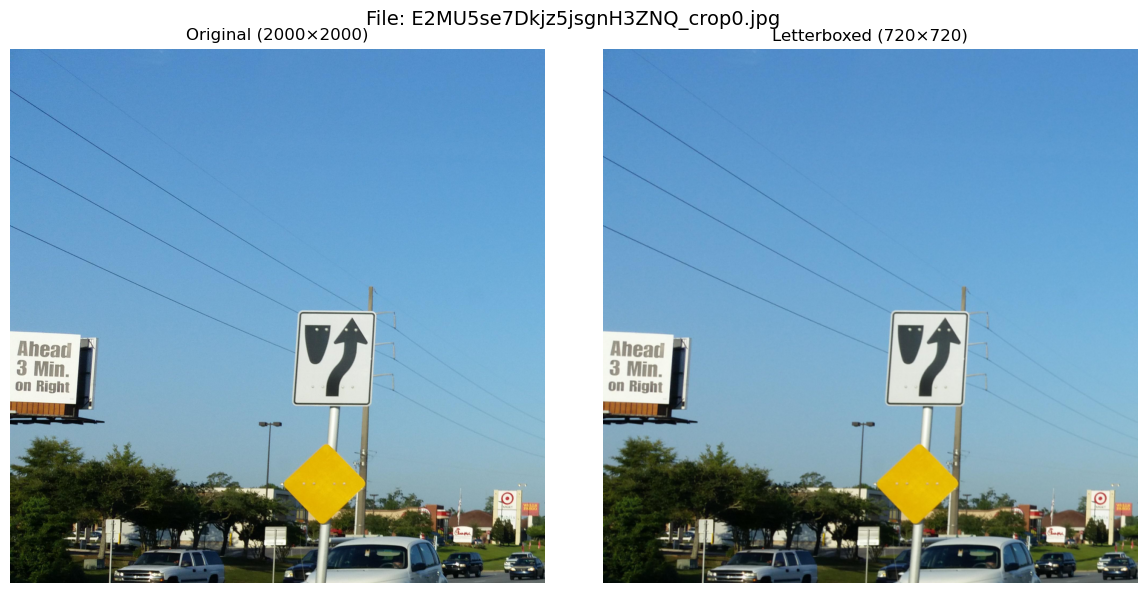

In [11]:
import sys
sys.path.append(str((Path(ROOT_PATH.resolve().parent.parent) / "Helper_Functions").resolve()))

print(sys.path)
# Import using the correct module path
from show_random_image_with_letterbox import show_random_image_with_letterbox

image_dir = OUTPUT_DIR / "images" / "train"
target_size = 720

show_random_image_with_letterbox(image_dir=image_dir, target_size=target_size)

## Tuning

In [ ]:
from ultralytics import YOLO
import time
import os
import gc
import logging

logging.getLogger().setLevel(logging.DEBUG)

logging.basicConfig(level=logging.DEBUG, format="%(message)s")

os.chdir(Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo").resolve())

model = YOLO("yolo11s-seg.pt")

start_tune = time.perf_counter()
model.tune(
    data=fr'{Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo").resolve()}\data.yaml',
    epochs=10,
    iterations=10,
    imgsz=720,
    project="runs",
    name="yolo11s_seg_tuning",
    exist_ok=True,
    save=True
)
end_tune = time.perf_counter()
logging.info(f"✅ Tuning abgeschlossen in {end_tune - start_tune:.2f} Sekunden.")



Tuner: Initialized Tuner instance with 'tune_dir=runs\yolo11s_seg_tuning2'
Tuner:  Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0}


## Training with best Model

In [ ]:
#(Nano Modell): Ging über 9h Training

logging.basicConfig(level=logging.INFO, format="%(message)s")
os.chdir(Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo").resolve())

# 🏁 Schritt 2: Training mit Early Stopping (nach Tuning)
start_train = time.perf_counter()
model = YOLO(r"D:\Masterarbeit\03_Model\Trained_Models\yolo11n-seg_tuning_10x10_trained_on_Mapillary_vistas\yolo11s_seg_tuning\weights\best.pt")
model.train(
    data=fr'{Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo").resolve()}/data.yaml',
    imgsz=720,
    task="segment",
    patience=5,
    save=True,
    save_period=1,
    project="runs",
    name="yolo11s_seg_train",
    exist_ok=True,
    device=0
)
end_train = time.perf_counter()
logging.info(f"✅ Training abgeschlossen in {end_train - start_train:.2f} Sekunden.")

gc.collect()

Ultralytics 8.3.169  Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=720, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=D:\Masterarbeit\03_Model\Trained_Models\yolo11n-seg_tuning_10x10_trained_on_Mapillary_vistas\yolo11s_seg_tuning\weights\best.pt, 

train: Scanning D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\labels\train.cache... 17885 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17885/17885 [00:00<?, ?it/s]

train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\0KrHv3TUtS-L10NF5jPl7w_crop1.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\1wEUR7gwJtgtiJtw1YnnSQ_crop0.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\236Va6kAUWR3Q5kd0ih76g_crop0.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\236Va6kAUWR3Q5kd0ih76g_crop1.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\2BVCxWq8IhiN7oqRODUGLg_crop0.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\dat

val: Fast image access  (ping: 0.00.0 ms, read: 3144.21060.4 MB/s, size: 378.9 KB)


val: Scanning D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\labels\val.cache... 6741 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6741/6741 [00:00<?, ?it/s]

val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\1wEUR7gwJtgtiJtw1YnnSQ_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\3eodkoH2NtePTDEpraGktg_crop1.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\42An0WlCDI7uMvTamNJsVg_crop1.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\4BR6X3rsY0isUHD6DtnXgw_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\5bIpd4WMBxjsghc4FN8I_A_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yol

Plotting labels to runs\yolo11s_seg_train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 736 train, 736 val
Using 8 dataloader workers
Logging results to runs\yolo11s_seg_train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      13.9G      1.342      3.229      1.622      1.279        737        736: 100%|██████████| 1118/1118 [04:26<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:38<00:00,  2.15it/s]


                   all       6741     356969      0.457      0.146      0.143     0.0917      0.431      0.112      0.104     0.0527

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.9G      1.349       3.23      1.592      1.288        741        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:30<00:00,  2.32it/s]


                   all       6741     356969      0.406       0.14      0.136     0.0842      0.371      0.104     0.0963     0.0481

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      15.7G      1.402      3.289      1.637       1.32        882        736: 100%|██████████| 1118/1118 [04:36<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:45<00:00,  2.00it/s]


                   all       6741     356969      0.428      0.126      0.126     0.0774      0.433     0.0908      0.089     0.0441

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.3G      1.417      3.316       1.66      1.339        929        736: 100%|██████████| 1118/1118 [04:17<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:27<00:00,  2.42it/s]


                   all       6741     356969      0.418      0.144      0.136     0.0825      0.404      0.108     0.0984     0.0488

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      14.4G      1.387      3.256      1.601      1.321        664        736: 100%|██████████| 1118/1118 [04:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:30<00:00,  2.33it/s]


                   all       6741     356969      0.436      0.151      0.146     0.0895      0.408      0.114      0.106     0.0525

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.7G      1.363      3.214       1.56      1.308        737        736: 100%|██████████| 1118/1118 [04:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:39<00:00,  2.12it/s]


                   all       6741     356969       0.43      0.159       0.15     0.0919      0.406      0.121      0.109     0.0539

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      13.4G      1.349      3.181      1.532      1.298       1154        736: 100%|██████████| 1118/1118 [04:19<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:31<00:00,  2.31it/s]


                   all       6741     356969      0.432      0.166      0.156     0.0969      0.403      0.127      0.117     0.0584

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100        13G       1.33      3.151      1.508      1.288        727        736: 100%|██████████| 1118/1118 [04:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:31<00:00,  2.31it/s]


                   all       6741     356969      0.395      0.174      0.164      0.102      0.382      0.135      0.124     0.0616

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      10.4G      1.319      3.134      1.488      1.283       1016        736: 100%|██████████| 1118/1118 [04:17<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:29<00:00,  2.36it/s]


                   all       6741     356969      0.403      0.181      0.171      0.106      0.392      0.138      0.126     0.0634

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.3G       1.31      3.111       1.47      1.275        644        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:26<00:00,  2.43it/s]


                   all       6741     356969      0.409      0.186      0.176       0.11      0.383      0.144      0.133     0.0673

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.2G      1.302      3.094      1.454      1.269        945        736: 100%|██████████| 1118/1118 [04:14<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.67it/s]


                   all       6741     356969      0.442      0.187      0.179      0.111      0.422      0.145      0.133     0.0672

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.8G      1.299      3.084      1.444      1.267        862        736: 100%|██████████| 1118/1118 [04:20<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:30<00:00,  2.33it/s]


                   all       6741     356969      0.414      0.192      0.187      0.116      0.387      0.151      0.138     0.0692

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.3G      1.284      3.063      1.429       1.26        997        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:26<00:00,  2.44it/s]


                   all       6741     356969      0.436      0.196      0.188      0.118      0.386      0.151      0.139     0.0702

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100        15G      1.284      3.058      1.422      1.258        673        736: 100%|██████████| 1118/1118 [04:36<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:16<00:00,  2.75it/s]


                   all       6741     356969      0.477      0.195      0.192      0.121      0.439      0.154      0.146      0.074

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      9.85G      1.277      3.047      1.415      1.255        910        736: 100%|██████████| 1118/1118 [04:19<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:26<00:00,  2.43it/s]


                   all       6741     356969      0.435      0.202      0.196      0.124      0.421      0.158      0.148      0.074

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.5G      1.274      3.038      1.404      1.251        854        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:25<00:00,  2.47it/s]


                   all       6741     356969      0.483      0.202      0.199      0.127      0.444      0.162      0.153     0.0766

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      11.8G      1.267      3.026      1.395      1.247       1026        736: 100%|██████████| 1118/1118 [04:20<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:26<00:00,  2.45it/s]


                   all       6741     356969      0.458      0.206      0.202      0.128      0.425      0.161      0.153     0.0771

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.2G      1.262      3.021      1.389      1.245        712        736: 100%|██████████| 1118/1118 [04:14<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.60it/s]


                   all       6741     356969      0.453       0.21      0.203      0.129      0.417      0.167      0.155     0.0781

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100        12G      1.258      3.009      1.383      1.243       1013        736: 100%|██████████| 1118/1118 [04:25<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:25<00:00,  2.46it/s]


                   all       6741     356969      0.439      0.214      0.208      0.133      0.429      0.169      0.159     0.0809

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.1G      1.255      3.004      1.377      1.241        763        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:25<00:00,  2.47it/s]


                   all       6741     356969      0.477      0.213       0.21      0.134      0.431       0.17      0.161      0.081

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100        13G      1.251      2.999      1.369      1.239        954        736: 100%|██████████| 1118/1118 [04:17<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:15<00:00,  2.81it/s]


                   all       6741     356969      0.468      0.215      0.214      0.137      0.426      0.171      0.164     0.0827

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      13.1G      1.248      2.992      1.366      1.237        573        736: 100%|██████████| 1118/1118 [04:19<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:23<00:00,  2.53it/s]


                   all       6741     356969      0.478       0.22      0.216      0.138      0.442      0.175      0.166     0.0838

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      11.9G      1.246      2.988      1.359      1.235        892        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:24<00:00,  2.51it/s]


                   all       6741     356969      0.465      0.224      0.219       0.14      0.434      0.179      0.168     0.0851

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100        14G      1.242      2.982      1.354      1.231        792        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:22<00:00,  2.57it/s]


                   all       6741     356969      0.464      0.225      0.222      0.142      0.424      0.179       0.17     0.0859

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.2G       1.24      2.969      1.348       1.23        943        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:22<00:00,  2.56it/s]


                   all       6741     356969      0.475      0.227      0.224      0.144      0.442      0.183      0.173     0.0869

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.3G      1.238      2.967      1.347      1.229       1021        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:22<00:00,  2.55it/s]


                   all       6741     356969      0.477      0.228      0.227      0.146      0.433      0.183      0.174     0.0883

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.6G      1.236       2.96       1.34      1.227        918        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:22<00:00,  2.56it/s]


                   all       6741     356969      0.483       0.23       0.23      0.149      0.465      0.186      0.178     0.0901

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100        12G      1.233      2.956      1.336      1.227        804        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.57it/s]


                   all       6741     356969      0.485      0.233      0.232       0.15      0.452      0.188       0.18     0.0911

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      11.3G      1.232      2.949      1.329      1.224        744        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.58it/s]


                   all       6741     356969      0.478      0.238      0.235      0.152      0.435      0.192      0.182     0.0922

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100        12G      1.227      2.945      1.326      1.222        979        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:22<00:00,  2.56it/s]


                   all       6741     356969       0.48      0.235      0.236      0.153      0.449      0.191      0.183     0.0929

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.5G      1.225      2.945      1.322      1.221       1026        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.59it/s]


                   all       6741     356969      0.489      0.234      0.237      0.154      0.459      0.188      0.183     0.0936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.6G      1.222      2.937      1.315      1.219        739        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.59it/s]


                   all       6741     356969      0.489      0.237       0.24      0.156      0.447       0.19      0.186      0.095

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      13.3G      1.222      2.933      1.315       1.22        664        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.60it/s]


                   all       6741     356969      0.484      0.238      0.242      0.158      0.463      0.192      0.188     0.0957

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.3G       1.22      2.927       1.31      1.218        907        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.60it/s]


                   all       6741     356969      0.482      0.239      0.243      0.158      0.439      0.194      0.188      0.096

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.4G      1.219      2.931       1.31      1.217        645        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.59it/s]


                   all       6741     356969      0.491      0.242      0.245       0.16      0.453      0.195      0.191     0.0969

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.3G      1.214      2.916      1.304      1.214        712        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.59it/s]


                   all       6741     356969      0.488      0.246      0.247      0.161      0.444      0.198      0.192     0.0984

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      15.3G      1.213      2.911      1.299      1.213        616        736: 100%|██████████| 1118/1118 [04:28<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.61it/s]


                   all       6741     356969      0.491      0.245      0.248      0.162      0.456      0.196      0.192     0.0982

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.7G      1.212      2.909      1.297      1.212        585        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.61it/s]


                   all       6741     356969      0.495      0.243       0.25      0.163      0.454      0.195      0.194     0.0989

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      13.3G      1.207      2.905      1.294      1.212        912        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.61it/s]


                   all       6741     356969      0.486      0.248      0.251      0.164       0.45      0.199      0.196        0.1

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      13.3G      1.208      2.906      1.292       1.21        927        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.61it/s]


                   all       6741     356969      0.487      0.249      0.252      0.165      0.449      0.202      0.196        0.1

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100        12G      1.205      2.901      1.288      1.209       1053        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.63it/s]


                   all       6741     356969      0.494      0.247      0.254      0.166      0.464      0.198      0.197      0.101

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.1G      1.204        2.9      1.285      1.207       1385        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.63it/s]


                   all       6741     356969      0.494      0.247      0.254      0.166      0.463      0.201      0.198      0.101

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      13.8G        1.2      2.893      1.281      1.204        617        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.63it/s]


                   all       6741     356969      0.502      0.249      0.255      0.167      0.471      0.201      0.199      0.102

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      13.7G        1.2      2.889      1.279      1.205        818        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.62it/s]


                   all       6741     356969        0.5       0.25      0.257      0.168      0.471      0.201        0.2      0.102

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.3G      1.201      2.888      1.278      1.206        963        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.63it/s]


                   all       6741     356969      0.507      0.249      0.258       0.17      0.466      0.204      0.201      0.103

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      12.1G      1.197      2.881      1.274      1.204        982        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.63it/s]


                   all       6741     356969      0.506       0.25      0.259       0.17      0.465      0.205      0.202      0.104

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      11.3G      1.195      2.881      1.269      1.201        781        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.63it/s]


                   all       6741     356969      0.508       0.25       0.26      0.171      0.475      0.203      0.203      0.104

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      11.7G      1.192      2.877      1.266        1.2        888        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.63it/s]


                   all       6741     356969      0.504      0.253      0.261      0.172      0.481      0.203      0.204      0.105

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      16.6G      1.192      2.871      1.265        1.2        693        736: 100%|██████████| 1118/1118 [04:45<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.64it/s]


                   all       6741     356969      0.506      0.254      0.262      0.173      0.471      0.206      0.205      0.106

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      13.6G      1.187      2.866      1.262      1.197       1167        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.62it/s]


                   all       6741     356969      0.509      0.254      0.263      0.174      0.475      0.206      0.206      0.106

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100        12G      1.188      2.867      1.259      1.197        984        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.64it/s]


                   all       6741     356969      0.507      0.255      0.264      0.174      0.476      0.208      0.207      0.107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      13.1G      1.185       2.86      1.255      1.197        784        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:20<00:00,  2.63it/s]


                   all       6741     356969      0.509      0.256      0.265      0.175      0.477      0.209      0.207      0.107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.2G      1.185      2.856      1.252      1.196        873        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.64it/s]


                   all       6741     356969      0.511      0.256      0.266      0.175      0.481      0.209      0.208      0.107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      13.1G      1.184      2.855      1.249      1.195        757        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.65it/s]


                   all       6741     356969       0.51      0.258      0.267      0.176      0.484      0.209      0.209      0.108

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.3G      1.181      2.847      1.246      1.194       1022        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.64it/s]


                   all       6741     356969      0.512      0.258      0.267      0.177      0.492      0.209       0.21      0.108

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.9G       1.18      2.841      1.244      1.192       1146        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.65it/s]


                   all       6741     356969      0.515      0.258      0.268      0.177      0.489       0.21       0.21      0.108

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      12.7G       1.18      2.848      1.242      1.192       1042        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.64it/s]


                   all       6741     356969      0.517      0.258      0.268      0.177       0.49       0.21       0.21      0.109

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.8G      1.177       2.84      1.237       1.19        752        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.65it/s]


                   all       6741     356969      0.517      0.258      0.269      0.178       0.49      0.209      0.211      0.109

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      15.5G      1.176      2.839      1.236      1.189        948        736: 100%|██████████| 1118/1118 [04:31<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.64it/s]


                   all       6741     356969      0.519      0.258       0.27      0.178      0.484      0.211      0.211      0.109

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      15.9G      1.174      2.834      1.234      1.188        986        736: 100%|██████████| 1118/1118 [04:37<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.65it/s]


                   all       6741     356969      0.521      0.259       0.27      0.179      0.485      0.212      0.212      0.109

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      10.9G      1.171      2.829      1.229      1.187        913        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.65it/s]


                   all       6741     356969      0.515      0.261      0.271      0.179      0.485      0.212      0.213       0.11

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.9G      1.173      2.831       1.23      1.188       1001        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.65it/s]


                   all       6741     356969      0.519      0.261      0.272       0.18      0.485      0.213      0.213       0.11

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      16.2G       1.17      2.825      1.226      1.187        814        736: 100%|██████████| 1118/1118 [06:14<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:21<00:00,  2.59it/s]


                   all       6741     356969      0.514      0.263      0.272       0.18      0.482      0.214      0.214       0.11

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      14.7G      1.168      2.821      1.222      1.185        990        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.66it/s]


                   all       6741     356969      0.514      0.262      0.273      0.181      0.476      0.215      0.214      0.111

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      13.4G      1.167      2.817       1.22      1.185        905        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.66it/s]


                   all       6741     356969      0.513      0.263      0.273      0.181      0.478      0.215      0.215      0.111

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100        14G      1.164      2.811      1.219      1.184        989        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.67it/s]


                   all       6741     356969      0.515      0.263      0.274      0.182      0.477      0.216      0.216      0.111

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      13.4G      1.163      2.809      1.216      1.182       1181        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.66it/s]


                   all       6741     356969      0.513      0.264      0.275      0.182       0.48      0.216      0.216      0.112

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100        14G      1.158      2.802      1.209       1.18        801        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.67it/s]


                   all       6741     356969      0.511      0.266      0.275      0.183      0.479      0.217      0.217      0.112

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      16.5G      1.156      2.799      1.208       1.18       1086        736: 100%|██████████| 1118/1118 [04:40<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.67it/s]


                   all       6741     356969      0.511      0.266      0.275      0.183      0.479      0.218      0.217      0.112

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      13.9G      1.157      2.797      1.207      1.179       1062        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.67it/s]


                   all       6741     356969      0.512      0.267      0.276      0.183      0.478      0.219      0.217      0.112

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      12.3G      1.156      2.792      1.199      1.178       1020        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.67it/s]


                   all       6741     356969      0.511      0.267      0.277      0.184      0.478      0.219      0.218      0.113

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      13.3G      1.156      2.793        1.2      1.177        924        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.67it/s]


                   all       6741     356969      0.512      0.268      0.277      0.184       0.48      0.218      0.218      0.113

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      13.1G      1.154      2.792      1.198      1.175        825        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.67it/s]


                   all       6741     356969      0.512      0.268      0.277      0.184      0.477      0.219      0.218      0.113

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      14.5G      1.149      2.781      1.195      1.175        885        736: 100%|██████████| 1118/1118 [04:21<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:19<00:00,  2.67it/s]


                   all       6741     356969      0.511      0.268      0.278      0.185      0.476       0.22      0.219      0.113

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.2G      1.152      2.785      1.193      1.174        900        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.68it/s]


                   all       6741     356969      0.511      0.268      0.279      0.185      0.478      0.219      0.219      0.114

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      12.6G      1.147      2.778      1.186      1.173        703        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.67it/s]


                   all       6741     356969      0.512      0.268      0.279      0.186      0.476       0.22       0.22      0.114

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      11.8G      1.148      2.773      1.186      1.172        966        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.67it/s]


                   all       6741     356969      0.512      0.268      0.279      0.186      0.477      0.219       0.22      0.114

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      12.2G      1.145       2.77      1.182      1.171        879        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.67it/s]


                   all       6741     356969      0.514      0.268       0.28      0.186      0.478      0.219      0.221      0.114

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100        13G      1.144      2.765      1.181      1.169       1028        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.68it/s]


                   all       6741     356969      0.514      0.268       0.28      0.187      0.475       0.22      0.221      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      12.6G       1.14      2.759      1.178      1.171        904        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.69it/s]


                   all       6741     356969      0.513      0.269      0.281      0.187      0.479       0.22      0.221      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      12.1G      1.138      2.754      1.171      1.167        839        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.69it/s]


                   all       6741     356969      0.512      0.269      0.281      0.187      0.477       0.22      0.222      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      12.4G       1.14      2.757      1.174      1.167        858        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.69it/s]


                   all       6741     356969      0.512       0.27      0.281      0.187      0.477       0.22      0.222      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      14.6G      1.136      2.746      1.167      1.166        937        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.68it/s]


                   all       6741     356969      0.512       0.27      0.282      0.188      0.476      0.221      0.223      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      13.7G      1.137      2.745      1.167      1.166        641        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.69it/s]


                   all       6741     356969      0.503      0.271      0.282      0.188      0.475      0.221      0.223      0.116

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      12.8G      1.134      2.743      1.163      1.164        708        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.69it/s]


                   all       6741     356969      0.503      0.271      0.282      0.188      0.474      0.222      0.223      0.116

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      13.9G       1.13      2.738      1.158      1.163        757        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.70it/s]


                   all       6741     356969      0.503      0.271      0.283      0.189      0.473      0.223      0.224      0.116

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      13.6G      1.128      2.731      1.155      1.161        701        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.70it/s]


                   all       6741     356969        0.5      0.272      0.283      0.189      0.475      0.223      0.224      0.116

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      12.6G      1.127      2.731      1.151      1.161       1007        736: 100%|██████████| 1118/1118 [04:22<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.70it/s]


                   all       6741     356969      0.501      0.273      0.284       0.19      0.476      0.223      0.225      0.117

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      12.3G      1.126      2.724      1.149       1.16        839        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.70it/s]


                   all       6741     356969      0.502      0.273      0.284       0.19      0.475      0.223      0.225      0.117

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      14.3G      1.126      2.725      1.145      1.158       1024        736: 100%|██████████| 1118/1118 [04:23<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.70it/s]


                   all       6741     356969      0.503      0.274      0.285       0.19      0.473      0.224      0.226      0.117
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      9.19G      1.223      2.662      1.197      1.194        529        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:17<00:00,  2.71it/s]


                   all       6741     356969      0.504      0.274      0.285      0.191      0.474      0.224      0.226      0.117

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      9.51G      1.218      2.654      1.186      1.191        671        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:17<00:00,  2.71it/s]


                   all       6741     356969      0.505      0.274      0.286      0.191      0.476      0.225      0.227      0.118

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      10.2G      1.212      2.644      1.177      1.188        702        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.70it/s]


                   all       6741     356969      0.507      0.275      0.287      0.192      0.464      0.226      0.227      0.118

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      11.8G      1.212      2.639      1.171      1.186        644        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:17<00:00,  2.71it/s]


                   all       6741     356969      0.506      0.276      0.287      0.192      0.467      0.226      0.228      0.118

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      11.5G      1.205      2.628      1.167      1.184        457        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.70it/s]


                   all       6741     356969      0.506      0.277      0.288      0.193      0.469      0.226      0.228      0.119

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      10.1G      1.203      2.621       1.16      1.182        665        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:18<00:00,  2.70it/s]


                   all       6741     356969      0.506      0.277      0.288      0.193      0.479      0.227      0.229      0.119

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      9.26G        1.2      2.622      1.157       1.18        425        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:17<00:00,  2.71it/s]


                   all       6741     356969      0.506      0.277      0.289      0.193       0.48      0.227      0.229      0.119

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      11.3G      1.198      2.615      1.153      1.177        610        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:17<00:00,  2.72it/s]


                   all       6741     356969      0.505      0.277      0.289      0.194      0.478      0.228       0.23      0.119

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      10.3G      1.195      2.612      1.149      1.178        589        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:17<00:00,  2.72it/s]


                   all       6741     356969      0.504      0.277      0.289      0.194      0.482      0.227       0.23       0.12

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100       9.5G      1.194      2.604      1.146      1.176        558        736: 100%|██████████| 1118/1118 [03:46<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:17<00:00,  2.71it/s]


                   all       6741     356969      0.504      0.278       0.29      0.194      0.482      0.227       0.23       0.12

100 epochs completed in 9.627 hours.
Optimizer stripped from runs\yolo11s_seg_train\weights\last.pt, 20.6MB
Optimizer stripped from runs\yolo11s_seg_train\weights\best.pt, 20.6MB

Validating runs\yolo11s_seg_train\weights\best.pt...
Ultralytics 8.3.169  Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLO11s-seg summary (fused): 113 layers, 10,114,417 parameters, 0 gradients, 35.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/211 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 1/211 [00:00<01:32,  2.27it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   1%|          | 2/211 [00:01<01:58,  1.76it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:04<00:00,  3.25it/s]


                   all       6741     356969      0.506      0.278       0.29      0.194      0.482      0.227       0.23       0.12
          animal--bird        152        232      0.295     0.0603     0.0758     0.0431      0.265     0.0474     0.0746     0.0275
 animal--ground-animal         48         62          1          0     0.0266     0.0154          1          0     0.0266     0.0132
construction--barrier--ambiguous         38         50          0          0          0          0          0          0          0          0
construction--barrier--concrete-block        574        945      0.539       0.48      0.496      0.324      0.475      0.387      0.371      0.186
construction--barrier--curb       4020      10791      0.491      0.367       0.38       0.23      0.435      0.284      0.278      0.115
construction--barrier--fence       2953       5135       0.49      0.383      0.387      0.233      0.439      0.303       0.28      0.121
construction--barrier--guard-rail

✅ Training abgeschlossen in 34813.93 Sekunden.


9

In [ ]:
# Yolo staged training:

logging.basicConfig(level=logging.INFO, format="%(message)s")
os.chdir(Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo_staged_ultrasmall").resolve())

# Schritt 2: Training with Early Stopping (Small Modell)
start_train = time.perf_counter()

model = YOLO("yolo11m-seg.pt")

model.train(
    data=fr'{Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo_staged_ultrasmall").resolve()}/data.yaml',
    imgsz=700,
    task="segment",
    patience=5,
    save=True,
    save_period=1,
    project="runs",
    name="yolo11m_segment_staged_train",
    exist_ok=True,
    device=0,
    epochs=100
    )

end_train = time.perf_counter()
logging.info(f"✅ Training abgeschlossen in {end_train - start_train:.2f} Sekunden.")

gc.collect()


100%|██████████| 43.3M/43.3M [00:00<00:00, 101MB/s] 


Ultralytics 8.3.170  Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo_staged_ultrasmall/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=700, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_segment_staged_train, nbs=64, nms=F

100%|██████████| 5.35M/5.35M [00:00<00:00, 31.8MB/s]


AMP: checks passed 
WARNING imgsz=[700] must be multiple of max stride 32, updating to [704]
train: Fast image access  (ping: 0.00.0 ms, read: 3291.9819.6 MB/s, size: 412.5 KB)


train: Scanning D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo_staged_ultrasmall\labels\train... 165 images, 0 backgrounds, 0 corrupt: 100%|██████████| 165/165 [00:00<00:00, 1159.33it/s]

train: New cache created: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo_staged_ultrasmall\labels\train.cache


val: Fast image access  (ping: 0.00.0 ms, read: 2894.8629.0 MB/s, size: 426.9 KB)


val: Scanning D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo_staged_ultrasmall\labels\val... 41 images, 0 backgrounds, 0 corrupt: 100%|██████████| 41/41 [00:00<00:00, 1019.16it/s]

val: New cache created: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo_staged_ultrasmall\labels\val.cache


Plotting labels to runs\yolo11m_segment_staged_train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=7.9e-05, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\yolo11m_segment_staged_train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      22.9G       1.85      5.011       5.21      1.656        473        704: 100%|██████████| 11/11 [01:25<00:00,  7.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         41       2274    0.00821     0.0127     0.0091    0.00704    0.00705     0.0127    0.00815    0.00389



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.9G      1.671      4.369      4.815       1.53        398        704: 100%|██████████| 11/11 [00:05<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.92it/s]

                   all         41       2274     0.0113     0.0447      0.025     0.0161    0.00783     0.0339     0.0157    0.00742



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      13.4G      1.579       3.89      4.281      1.433        377        704: 100%|██████████| 11/11 [00:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         41       2274      0.892     0.0169     0.0286     0.0199       0.89     0.0124     0.0216    0.00865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.7G      1.509      3.691      3.665      1.405        371        704: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.68it/s]

                   all         41       2274      0.447     0.0384     0.0399     0.0275      0.428     0.0294     0.0255     0.0109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.9G      1.433      3.558       3.14      1.371        181        704: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         41       2274      0.415     0.0561     0.0454     0.0294      0.398     0.0462     0.0312     0.0128



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100        13G      1.417      3.429      2.827      1.346        340        704: 100%|██████████| 11/11 [00:03<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all         41       2274      0.596     0.0544     0.0592     0.0392      0.556     0.0422      0.045     0.0218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.9G      1.403      3.399      2.514      1.334        292        704: 100%|██████████| 11/11 [00:03<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         41       2274      0.519       0.08     0.0643     0.0433      0.469     0.0654     0.0502     0.0232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.8G      1.351      3.306      2.307      1.315        227        704: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         41       2274      0.546     0.0695     0.0671     0.0456      0.534     0.0583     0.0541      0.026



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      13.1G      1.381       3.28      2.236      1.313        343        704: 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         41       2274      0.508     0.0756     0.0709     0.0485      0.531     0.0532     0.0567     0.0289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      13.1G       1.38      3.209      2.114      1.301        367        704: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         41       2274      0.476     0.0776     0.0781     0.0538      0.462     0.0622      0.062     0.0311



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      13.1G      1.337      3.181      1.983      1.284        414        704: 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         41       2274      0.496     0.0868     0.0803      0.055      0.481     0.0684     0.0662     0.0323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      13.1G      1.331      3.159      1.917       1.28        682        704: 100%|██████████| 11/11 [00:03<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         41       2274      0.468     0.0912     0.0816     0.0553      0.467     0.0739     0.0674     0.0325



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      13.3G      1.273        3.1      1.842      1.248        358        704: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         41       2274      0.478     0.0916     0.0862     0.0583       0.52     0.0683     0.0698     0.0326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.8G      1.248      3.047      1.774      1.251        346        704: 100%|██████████| 11/11 [00:03<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         41       2274      0.491     0.0987     0.0939     0.0614      0.473     0.0802     0.0721      0.035



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.9G      1.271      3.009      1.757      1.239        607        704: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         41       2274      0.492     0.0949     0.0956     0.0623      0.471     0.0789     0.0749     0.0383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100        13G      1.259      3.043      1.676      1.248        415        704: 100%|██████████| 11/11 [00:03<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         41       2274      0.539     0.0961      0.106     0.0654       0.52     0.0771     0.0761     0.0401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.6G      1.222      2.955      1.619      1.229        394        704: 100%|██████████| 11/11 [00:03<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         41       2274      0.566     0.0921      0.102     0.0635      0.544     0.0738     0.0766      0.039



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      13.4G      1.228      2.916      1.621      1.224        498        704: 100%|██████████| 11/11 [00:03<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         41       2274      0.568      0.105      0.107     0.0648      0.587      0.074     0.0773     0.0394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      13.2G      1.214      2.908      1.589      1.218        253        704: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         41       2274      0.583     0.0976      0.107     0.0703      0.584     0.0796      0.082     0.0419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      13.2G      1.219      2.928      1.562      1.221        393        704: 100%|██████████| 11/11 [00:03<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         41       2274        0.6      0.109      0.107     0.0713      0.592     0.0849     0.0859     0.0424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      13.5G      1.235      2.961      1.587      1.232        389        704: 100%|██████████| 11/11 [00:03<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.69it/s]

                   all         41       2274      0.608       0.11      0.118     0.0768      0.586     0.0884     0.0914     0.0427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.9G      1.188      2.848      1.479        1.2        350        704: 100%|██████████| 11/11 [00:03<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         41       2274      0.585      0.115      0.122     0.0793      0.627     0.0795     0.0947      0.047



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      13.1G      1.182      2.876      1.504      1.213        234        704: 100%|██████████| 11/11 [00:03<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         41       2274       0.58     0.0984      0.123     0.0791      0.587     0.0781     0.0916     0.0492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.9G      1.181      2.807      1.476      1.202        443        704: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         41       2274      0.508      0.124      0.123     0.0779      0.495      0.097      0.094     0.0475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100        13G      1.167       2.85      1.432      1.205        364        704: 100%|██████████| 11/11 [00:03<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         41       2274      0.503      0.127      0.122     0.0783      0.484      0.103     0.0933     0.0462



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      13.1G      1.177      2.837      1.423        1.2        448        704: 100%|██████████| 11/11 [00:03<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         41       2274      0.619     0.0997      0.126     0.0819      0.598      0.083     0.0978     0.0498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      13.5G      1.144      2.757      1.379      1.178        477        704: 100%|██████████| 11/11 [00:03<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]

                   all         41       2274      0.625      0.103      0.127      0.083      0.603     0.0874     0.0999     0.0513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100        13G      1.151      2.763      1.371      1.183        548        704: 100%|██████████| 11/11 [00:03<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         41       2274      0.536      0.113      0.125     0.0826      0.495     0.0935     0.0986     0.0502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100        13G      1.156      2.696      1.362      1.174        336        704: 100%|██████████| 11/11 [00:03<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.70it/s]

                   all         41       2274      0.515       0.12      0.125      0.084      0.492     0.0983      0.101     0.0516



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      13.4G      1.149      2.701      1.349      1.183        391        704: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.67it/s]

                   all         41       2274      0.532      0.122      0.127     0.0865      0.502      0.102      0.106      0.054



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      13.9G      1.124       2.68      1.323      1.184        296        704: 100%|██████████| 11/11 [00:03<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.73it/s]

                   all         41       2274      0.494      0.122      0.136     0.0891      0.474      0.103      0.105     0.0551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      13.1G      1.129      2.701      1.332      1.174        503        704: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         41       2274      0.495      0.125      0.136     0.0869      0.544       0.09      0.101     0.0526



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.9G      1.113       2.65      1.306      1.168        528        704: 100%|██████████| 11/11 [00:03<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.71it/s]

                   all         41       2274      0.524      0.115      0.132     0.0833      0.535     0.0881     0.0961     0.0498



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      13.2G      1.105      2.616      1.278      1.162        483        704: 100%|██████████| 11/11 [00:03<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         41       2274      0.481      0.131      0.132     0.0833      0.535     0.0893     0.0957     0.0492



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      13.4G      1.114      2.629      1.273       1.16        298        704: 100%|██████████| 11/11 [00:03<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         41       2274      0.497      0.133      0.137     0.0875      0.495     0.0905     0.0976      0.051



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.9G      1.116      2.692      1.274      1.173        356        704: 100%|██████████| 11/11 [00:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         41       2274       0.49      0.127      0.129      0.085      0.466      0.103      0.104     0.0529


EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 31, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

36 epochs completed in 0.075 hours.
Optimizer stripped from runs\yolo11m_segment_staged_train\weights\last.pt, 45.4MB
Optimizer stripped from runs\yolo11m_segment_staged_train\weights\best.pt, 45.4MB

Validating runs\yolo11m_segment_staged_train\weights\best.pt...
Ultralytics 8.3.170  Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLO11m-seg summary (fused): 138 layers, 22,430,145 parameters, 0 gradients, 123.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/2 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:00<00:00,  2.70it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


                   all         41       2274      0.492      0.131      0.137     0.0892      0.474      0.103      0.105     0.0546
          animal--bird          1          1          0          0          0          0          0          0          0          0
construction--barrier--concrete-block          4          6      0.191      0.167      0.199       0.15          0          0          0          0
construction--barrier--curb         27         92      0.267      0.196      0.132     0.0517      0.109     0.0761     0.0389     0.0104
construction--barrier--fence         16         31     0.0722      0.161     0.0868     0.0228      0.047     0.0968     0.0188    0.00967
construction--barrier--guard-rail          4          6      0.364      0.167       0.21      0.171      0.434      0.167       0.21     0.0839
construction--barrier--road-median          1          1          0          0          0          0          0          0          0          0
construction--barrie

✅ Training abgeschlossen in 307.72 Sekunden.


10

In [17]:
# resume training for 10 epochs
data_path = Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo").resolve()
best_model_path = ROOT_PATH / "data" / "Mapillary_Vistas_Yolo_staged_ultrasmall" / "runs" / "yolo11m_segment_staged_finetune" / "weights" / "best.pt"
print(best_model_path)
model = YOLO(str(best_model_path))

model.train(
    data=fr"{data_path}/data.yaml",
    imgsz=700,
    task="segment",
    epochs=10,
    patience=5,
    save=True,
    save_period=1,
    project="runs",
    name="yolo11m_segment_staged_finetune_2",
    exist_ok=True,
    device=0
)

D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo_staged_ultrasmall\runs\yolo11m_segment_staged_finetune\weights\best.pt
Ultralytics 8.3.170  Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=700, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4,

train: Scanning D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\labels\train.cache... 17885 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17885/17885 [00:00<?, ?it/s]

train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\0KrHv3TUtS-L10NF5jPl7w_crop1.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\1wEUR7gwJtgtiJtw1YnnSQ_crop0.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\236Va6kAUWR3Q5kd0ih76g_crop0.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\236Va6kAUWR3Q5kd0ih76g_crop1.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\train\2BVCxWq8IhiN7oqRODUGLg_crop0.jpg: 1 duplicate labels removed
train: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\dat

val: Fast image access  (ping: 0.10.1 ms, read: 801.4194.7 MB/s, size: 378.9 KB)


val: Scanning D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\labels\val.cache... 6741 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6741/6741 [00:00<?, ?it/s]

val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\1wEUR7gwJtgtiJtw1YnnSQ_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\3eodkoH2NtePTDEpraGktg_crop1.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\42An0WlCDI7uMvTamNJsVg_crop1.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\4BR6X3rsY0isUHD6DtnXgw_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\5bIpd4WMBxjsghc4FN8I_A_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yol

Plotting labels to runs\yolo11m_segment_staged_finetune_2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=7.9e-05, momentum=0.9) with parameter groups 115 weight(decay=0.0), 126 weight(decay=0.0005), 125 bias(decay=0.0)
Image sizes 704 train, 704 val
Using 8 dataloader workers
Logging results to runs\yolo11m_segment_staged_finetune_2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/10        13G       1.24      2.768      1.315      1.216        465        704: 100%|██████████| 1118/1118 [06:08<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:29<00:00,  2.37it/s]


                   all       6741     356969      0.451      0.224      0.223      0.146      0.431      0.181      0.174     0.0885

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/10      13.1G      1.257      2.796      1.338      1.226        422        704: 100%|██████████| 1118/1118 [06:03<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:28<00:00,  2.38it/s]


                   all       6741     356969      0.432      0.227       0.22      0.143      0.398      0.181      0.168     0.0858

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/10      13.7G      1.264      2.801      1.338       1.23        377        704: 100%|██████████| 1118/1118 [05:57<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:38<00:00,  2.14it/s]


                   all       6741     356969      0.437      0.229      0.225      0.148      0.405      0.185      0.175     0.0885

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/10      12.9G      1.257      2.786      1.322      1.226        357        704: 100%|██████████| 1118/1118 [05:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:35<00:00,  2.20it/s]


                   all       6741     356969      0.455      0.232      0.233      0.153      0.413       0.19      0.181      0.092

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/10      14.2G      1.243      2.756      1.292      1.217        510        704: 100%|██████████| 1118/1118 [05:59<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:34<00:00,  2.24it/s]


                   all       6741     356969      0.465      0.245      0.244      0.162      0.432      0.197       0.19      0.097

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/10      13.5G      1.228      2.725      1.263      1.206        467        704: 100%|██████████| 1118/1118 [05:58<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:32<00:00,  2.27it/s]


                   all       6741     356969      0.471      0.248      0.251      0.166      0.438      0.201      0.195     0.0984

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/10      12.6G      1.213      2.695      1.239      1.198        531        704: 100%|██████████| 1118/1118 [05:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:34<00:00,  2.24it/s]


                   all       6741     356969      0.489      0.255      0.259      0.172      0.447      0.207      0.202      0.104

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/10      12.6G      1.201      2.669      1.217      1.191        387        704: 100%|██████████| 1118/1118 [05:57<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:33<00:00,  2.26it/s]


                   all       6741     356969      0.473      0.261      0.269       0.18      0.471      0.211       0.21      0.108

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/10      13.1G      1.188      2.643      1.195      1.183        532        704: 100%|██████████| 1118/1118 [05:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:33<00:00,  2.26it/s]


                   all       6741     356969      0.487      0.263      0.273      0.183      0.458      0.214      0.213      0.111

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/10        14G      1.179      2.622      1.178      1.176        567        704: 100%|██████████| 1118/1118 [05:53<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:24<00:00,  2.50it/s]


                   all       6741     356969      0.488      0.269      0.279      0.188      0.454      0.221      0.218      0.113

10 epochs completed in 1.277 hours.
Optimizer stripped from runs\yolo11m_segment_staged_finetune_2\weights\last.pt, 45.4MB
Optimizer stripped from runs\yolo11m_segment_staged_finetune_2\weights\best.pt, 45.4MB

Validating runs\yolo11m_segment_staged_finetune_2\weights\best.pt...
Ultralytics 8.3.170  Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLO11m-seg summary (fused): 138 layers, 22,430,145 parameters, 0 gradients, 123.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/211 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 1/211 [00:00<02:22,  1.47it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   1%|          | 2/211 [00:01<02:22,  1.47it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 211/211 [01:13<00:00,  2.87it/s]


                   all       6741     356969      0.488      0.269      0.279      0.188      0.454      0.221      0.218      0.113
          animal--bird        152        232      0.456      0.121      0.107     0.0551      0.336     0.0819     0.0572     0.0215
 animal--ground-animal         48         62      0.435     0.0968      0.117     0.0886      0.442     0.0968      0.121     0.0784
construction--barrier--ambiguous         38         50          0          0          0          0          0          0          0          0
construction--barrier--concrete-block        574        945      0.539      0.448      0.454      0.297      0.488      0.365      0.349      0.178
construction--barrier--curb       4020      10791      0.493      0.358      0.366      0.222      0.437      0.281       0.27      0.113
construction--barrier--fence       2953       5135      0.499      0.356      0.359      0.212      0.436       0.28      0.252      0.109
construction--barrier--guard-rail

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000021E38151350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Preci

# Validation of the Trained Model

In [32]:
# Validieren
model = YOLO(fr'{Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo_small").resolve()}/runs/yolo11s_seg_train/weights/best.pt')

results = model.val(
    data=fr'{Path(ROOT_PATH / "data" / "Mapillary_Vistas_Yolo").resolve()}/data.yaml',
    imgsz=720
)


WARNING imgsz=[720] must be multiple of max stride 32, updating to [736]
Ultralytics 8.3.169  Python-3.11.11 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLO11m-seg summary (fused): 138 layers, 22,430,145 parameters, 0 gradients, 123.5 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 3091.7739.9 MB/s, size: 375.3 KB)


val: Scanning D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\labels\val.cache... 6741 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6741/6741 [00:00<?, ?it/s]

val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\1wEUR7gwJtgtiJtw1YnnSQ_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\3eodkoH2NtePTDEpraGktg_crop1.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\42An0WlCDI7uMvTamNJsVg_crop1.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\4BR6X3rsY0isUHD6DtnXgw_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yolo\images\val\5bIpd4WMBxjsghc4FN8I_A_crop0.jpg: 1 duplicate labels removed
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\data\Mapillary_Vistas_Yol


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/422 [00:00<?, ?it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 1/422 [00:01<08:06,  1.15s/it]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 2/422 [00:01<05:01,  1.39it/s]

WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validation plots to first 50 items per image for speed...
WARNING Limiting validati

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 422/422 [01:41<00:00,  4.16it/s]


                   all       6741     356969      0.562      0.101     0.0989     0.0643      0.554     0.0808     0.0738     0.0365
          animal--bird        152        232          1          0          0          0          1          0          0          0
 animal--ground-animal         48         62          0          0          0          0          0          0          0          0
construction--barrier--ambiguous         38         50          0          0          0          0          0          0          0          0
construction--barrier--concrete-block        574        945      0.279      0.168      0.128     0.0723      0.229      0.123     0.0798     0.0346
construction--barrier--curb       4020      10791      0.315      0.222       0.18     0.0931      0.177      0.109     0.0656     0.0214
construction--barrier--fence       2953       5135      0.231      0.169      0.113     0.0564      0.183      0.118     0.0665     0.0238
construction--barrier--guard-rail

# Validation of all classes

In [ ]:
from ultralytics import YOLO
import pandas as pd

# === Input paths ===
data_yaml = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\models\data.yaml"
model_path = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\models\M4.pt"

# === Load and validate M4 ===
print("\n=== Evaluating M4 ===")
model = YOLO(model_path)
metrics = model.val(data=data_yaml, split="val", save_json=True, device=0)

# === Extract per-class results ===
results = metrics.summary()
df = pd.DataFrame(results)
df.to_csv("./models/M4_per_class_results.csv", index=False)



=== Evaluating M4 ===
Ultralytics 8.3.203  Python-3.10.18 torch-2.8.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLO11s-seg summary (fused): 113 layers, 10,114,417 parameters, 0 gradients, 33.0 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 2997.6642.8 MB/s, size: 361.3 KB)
val: Scanning D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\models\labels\val... 298 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 298/298 926.4it/s 0.3s0.0s
val: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\models\images\val\2BVCxWq8IhiN7oqRODUGLg_crop0.jpg: 1 duplicate labels removed
val: New cache created: D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\models\labels\val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 19/19 0.0it/s 12:0640.5s
                   all        298      15596      0.524  

In [1]:
from ultralytics import YOLO
import pandas as pd
import os

# === Input paths ===
data_yaml = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\models\data.yaml"
model_path = r"D:\Masterarbeit\03_Model\Scripts\2_Feature_Geolocation\2_1_Model_Mapillary\models\M4.pt"

# === Load and validate M4 ===
print("\n=== Evaluating M4 ===")
model = YOLO(model_path)

img_folder = r"D:\Masterarbeit\05_Masterarbeit\Kapitel\5_Results\img\Models_mapillary\img"
image_files = [os.path.join(img_folder, f) for f in os.listdir(img_folder) 
               if f.lower().endswith((".jpg", ".png", ".jpeg"))]

print("\n=== Predicting on images ===")
results = model.predict(image_files, save=True, device=0, save_txt=True, conf=0.25)


=== Evaluating M4 ===

=== Predicting on images ===

0: 736x736 1 construction--barrier--curb, 1 construction--barrier--fence, 1 construction--barrier--road-median, 1 construction--barrier--separator, 1 construction--flat--road, 1 construction--structure--building, 2 marking--continuous--dasheds, 1 marking--continuous--solid, 2 nature--skys, 2 nature--vegetations, 1 object--sign--store, 4 object--street-lights, 3 object--support--poles, 1 object--support--traffic-sign-frame, 1 object--traffic-sign--direction-back, 2 object--traffic-sign--fronts, 3 object--vehicle--cars, 218.2ms
1: 736x736 1 construction--flat--road, 2 nature--skys, 2 nature--terrains, 1 nature--vegetation, 218.2ms
2: 736x736 1 construction--barrier--curb, 1 construction--flat--pedestrian-area, 1 construction--flat--road, 1 construction--structure--building, 2 nature--skys, 5 nature--vegetations, 1 object--catch-basin, 1 object--sign--advertisement, 1 object--street-light, 5 object--support--poles, 5 void--statics, 218